# Iris Classification

This is an evaluation of common machine learning algorithms on the classic Iris data set. The model is intended to classify an iris into 3 possible classes based on the width and length of the sepal and petal.


Loading libraries:

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from numpy import std
import sklearn.discriminant_analysis
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
import sklearn.metrics
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.covariance import empirical_covariance
from sklearn.ensemble import GradientBoostingClassifier

Loading Data:

In [4]:
df=pd.read_csv('C:\Datasets\iris.txt')

Shuffle data for cross validation. 5-fold (80/20) cross validation will be used throughout.

In [5]:
df = shuffle(df)

### Data Visualization and Exploration

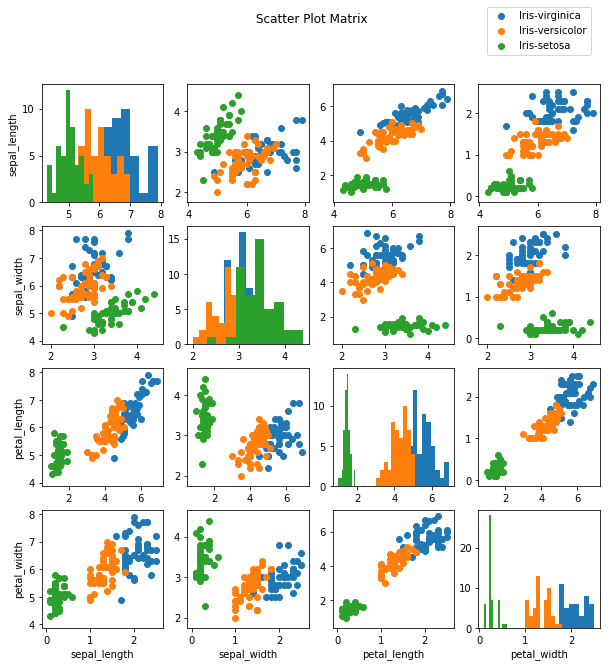

In [10]:
header = list(df)
species = list(set(df.iloc[:,4]))
for x in species:
    globals().update({str(x): df[df['species'] == x]})
fig1, ax1 = plt.subplots(4,4)
for i in range(0,4):
    for j in range(0,4):
        for x in species:
            if i != j:
                ax1[i,j].scatter(globals()[x].iloc[:,i],globals()[x].iloc[:,j])
            else:
                ax1[i, j].hist(globals()[x].iloc[:, i])
            if i == 3:
                ax1[i, j].set_xlabel(header[j])
            if j==0:
                ax1[i, j].set_ylabel(header[i])
ax1[0,3].legend(species,bbox_to_anchor=(0.5,1.7),loc='upper center')
fig1.suptitle('Scatter Plot Matrix')
fig1.set_size_inches(10,10)

Iris-setosa is well separated from the other two species, but iris-virginica and iris-versicolor are overlapping slightly.

Next calculate covariance matrix to check some of the assumptions of the machine learning algorithms.

In [11]:
for x in species:
    print('\nCovariance for '+str(x))
    print(empirical_covariance(globals()[x].iloc[:,:4]))


Covariance for Iris-virginica
[[0.396256 0.091888 0.297224 0.048112]
 [0.091888 0.101924 0.069952 0.046676]
 [0.297224 0.069952 0.298496 0.047848]
 [0.048112 0.046676 0.047848 0.073924]]

Covariance for Iris-versicolor
[[0.261104 0.08348  0.17924  0.054664]
 [0.08348  0.0965   0.081    0.04038 ]
 [0.17924  0.081    0.2164   0.07164 ]
 [0.054664 0.04038  0.07164  0.038324]]

Covariance for Iris-setosa
[[0.121764 0.098292 0.015816 0.010336]
 [0.098292 0.142276 0.011448 0.011208]
 [0.015816 0.011448 0.029504 0.005584]
 [0.010336 0.011208 0.005584 0.011264]]


It is apparent that covariance is not the same for each class (an assumption of Linear Discriminant Analysis) and that the covariance matrix is not close to diagonal for any class (an assumption for Naive Bayes). Based on the histograms, it is difficult to tell if the data is normal, given the small number of samples. It seems that the assumptions of Linear Discriminant Analysis and Naive Bayes will not be met, however the techniques will still be evaluated.

### Pre-processing

The data will be scaled by the standard deviation, in order to use algorithms that involve distance calculations (e.g. nearest neighbors).

In [12]:
def normalize(dataframe):
    global sdlist
    dfcopy = dataframe.iloc[:,:]
    sdlist = []
    for i in range(0,4):
        sd = std(dfcopy.iloc[:,i])
        sdlist.append(sd)
        dfcopy.iloc[:, i]/=sd
    return dfcopy

rescaleddf = normalize(df)

X = rescaleddf.iloc[:,:4]
y = rescaleddf.iloc[:,-1]

### Modeling

First a function to display the results will be created.

In [13]:
def printresults():
    print('Accuracy: ' + str(sklearn.metrics.accuracy_score(y, ypredict)))
    print('Recall:')
    print(sklearn.metrics.recall_score(y, ypredict, average=None))
    print('Precision:')
    print(sklearn.metrics.precision_score(y, ypredict, average=None))
    print('5-Fold Cross-Validation Mean Accuracy:')

#### Linear Discriminant Analysis

In [14]:
LDA = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
LDA.fit(X,y)
ypredict = LDA.predict(X)
print('\nLinear Discriminant Analysis')
printresults()
print(sum(cross_val_score(LDA,X,y,cv=5))/5)


Linear Discriminant Analysis
Accuracy: 0.98
Recall:
[1.   0.96 0.98]
Precision:
[1.         0.97959184 0.96078431]
5-Fold Cross-Validation Mean Accuracy:
0.9800000000000001


#### Quadratic Discriminant Analysis

In [15]:
QDA = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
QDA.fit(X,y)
ypredict = QDA.predict(X)
print('\nQuadratic Discriminant Analysis')
printresults()
print(sum(cross_val_score(QDA,X,y,cv=5))/5)


Quadratic Discriminant Analysis
Accuracy: 0.98
Recall:
[1.   0.96 0.98]
Precision:
[1.         0.97959184 0.96078431]
5-Fold Cross-Validation Mean Accuracy:
0.9733333333333334


#### Gaussian Naive Bayes

In [16]:
GNB = GaussianNB()
GNB.fit(X,y)
ypredict = GNB.predict(X)
print('\nGaussian Naive Bayes')
printresults()
print(sum(cross_val_score(GNB,X,y,cv=5))/5)


Gaussian Naive Bayes
Accuracy: 0.96
Recall:
[1.   0.94 0.94]
Precision:
[1.   0.94 0.94]
5-Fold Cross-Validation Mean Accuracy:
0.9533333333333334


#### Support Vector Machine

Hyperparameters will be screened first.

In [35]:
grid = [{'kernel': ['linear', 'poly', 'rbf'], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'C': [1, 10, 100, 1000]}]
SVM = svm.SVC(decision_function_shape='ovr')
clf = GridSearchCV(SVM, grid, cv=5, iid=False)
clf.fit(X, y)
print(clf.best_params_)
ypredict = clf.predict(X)
print(sklearn.metrics.accuracy_score(y, ypredict))
print(sklearn.metrics.recall_score(y, ypredict, average=None))
print(sklearn.metrics.precision_score(y, ypredict, average=None))

{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
0.9666666666666667
[1.   0.92 0.98]
[1.        0.9787234 0.9245283]


In [43]:
SVM = svm.SVC(kernel='linear',C=1,gamma=0.1,decision_function_shape='ovr')
SVM.fit(X, y)
ypredict = SVM.predict(X)
print('\nSupport Vector Machine (Linear)')
printresults()
print(sum(cross_val_score(SVM,X,y,cv=5))/5)


Support Vector Machine (Linear)
Accuracy: 0.9666666666666667
Recall:
[1.   0.92 0.98]
Precision:
[1.        0.9787234 0.9245283]
5-Fold Cross-Validation Mean Accuracy:
0.9800000000000001


#### k Nearest Neighbors

First, find the best value for k.

In [37]:
grid = [{'n_neighbors':[11,12,13,14,15,16,17,18,19,20]}]
KNN = KNeighborsClassifier()
clf = GridSearchCV(KNN,grid,cv=5,iid=False)
clf.fit(X,y)
print(clf.best_params_)
ypredict = clf.predict(X)
print(sklearn.metrics.accuracy_score(y, ypredict))
print(sklearn.metrics.recall_score(y, ypredict, average=None))
print(sklearn.metrics.precision_score(y, ypredict, average=None))

{'n_neighbors': 13}
0.9666666666666667
[1.   0.96 0.94]
[1.         0.94117647 0.95918367]


In [38]:
KNN = KNeighborsClassifier(n_neighbors=13)
KNN.fit(X,y)
ypredict = KNN.predict(X)
print('\nk Nearest Neighbors (k=13)')
printresults()
print(sum(cross_val_score(KNN,X,y,cv=5))/5)


k Nearest Neighbors (k=13)
Accuracy: 0.9666666666666667
Recall:
[1.   0.96 0.94]
Precision:
[1.         0.94117647 0.95918367]
5-Fold Cross-Validation Mean Accuracy:
0.9666666666666666


#### Logistic Regression

In [44]:
LR = LogisticRegression(solver='liblinear',multi_class='ovr')
LR.fit(X,y)
ypredict = LR.predict(X)
print('\nLogistic Regression')
printresults()
print(sum(cross_val_score(LR,X,y,cv=5))/5)


Logistic Regression
Accuracy: 0.96
Recall:
[1.   0.92 0.96]
Precision:
[1.         0.95833333 0.92307692]
5-Fold Cross-Validation Mean Accuracy:
0.9399999999999998


#### Gradient Boosted Tree

First tune hyperparameters.

In [45]:
grid=[{'learning_rate':[0.01,0.025,0.05,0.1],'n_estimators':[30,40,50,60,70],'max_depth':[2,3,4,5]}]
GB = GradientBoostingClassifier()
clf = GridSearchCV(GB,grid,cv=5,iid=False)
clf.fit(X, y)
print(clf.best_params_)
ypredict = clf.predict(X)
print(sklearn.metrics.accuracy_score(y, ypredict))
print(sklearn.metrics.recall_score(y, ypredict, average=None))
print(sklearn.metrics.precision_score(y, ypredict, average=None))

{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 50}
0.9866666666666667
[1.   0.96 1.  ]
[1.         1.         0.96153846]


In [46]:
GB = GradientBoostingClassifier(learning_rate=0.05, max_depth=2, n_estimators=50)
GB.fit(X,y)
ypredict = GB.predict(X)
print('\nGradient Boosted Trees')
printresults()
print(sum(cross_val_score(LR,X,y,cv=5))/5)


Gradient Boosted Trees
Accuracy: 0.9866666666666667
Recall:
[1.   0.96 1.  ]
Precision:
[1.         1.         0.96153846]
5-Fold Cross-Validation Mean Accuracy:
0.9399999999999998


#### Comparing LDA and SVM

Since LDA and SVM have the same cross validation accuracy, the data is reshuffled and LDA and SVM are compared.

In [48]:
for i in range(5):
    df = shuffle(df)
    rescaleddf = normalize(df)
    X = rescaleddf.iloc[:,:4]
    y = rescaleddf.iloc[:,-1]

    print('LDA 5-Fold Cross-Validation Mean Accuracy:')
    print(sum(cross_val_score(LDA,X,y,cv=5))/5)

    print('SVM 5-Fold Cross-Validation Mean Accuracy:')
    print(sum(cross_val_score(SVM,X,y,cv=5))/5)

LDA 5-Fold Cross-Validation Mean Accuracy:
0.9733333333333334
SVM 5-Fold Cross-Validation Mean Accuracy:
0.9600000000000002
LDA 5-Fold Cross-Validation Mean Accuracy:
0.9733333333333334
SVM 5-Fold Cross-Validation Mean Accuracy:
0.9466666666666667
LDA 5-Fold Cross-Validation Mean Accuracy:
0.9800000000000001
SVM 5-Fold Cross-Validation Mean Accuracy:
0.9733333333333334
LDA 5-Fold Cross-Validation Mean Accuracy:
0.9800000000000001
SVM 5-Fold Cross-Validation Mean Accuracy:
0.96
LDA 5-Fold Cross-Validation Mean Accuracy:
0.9800000000000001
SVM 5-Fold Cross-Validation Mean Accuracy:
0.9666666666666668


In repeated cross validation, LDA performs consistently better than SVM.

### Discussion

Despite the assumptions not being met, Linear Discriminant Analysis and Naive Bayes models still perform remarkably well, and Linear Discriminant Analysis is one of the best performing algorithms.

Overall, Gradient Boosted Trees has the best accuracy, precision, and recall using the entire data set, but has a low cross validation score, indicating overfitting. 

Algorithms that find hyperplanes maximizing separation between  groups (Linear Discriminant and Linear Support Vector Machine) perform slightly better than other algorithms. Linear Discriminant Analysis is the most accurate model in repeated cross validations. This is because it uses characteristics of the entire class rather than boundary points (support vectors, nearest neighbors) which vary more during cross validation.

Therefore, LDA is chosen as the final model. The confusion matrix is displayed below (with species listed in alphabetical order).

In [51]:
sklearn.metrics.confusion_matrix(y, LDA.predict(X))

array([[50,  0,  0],
       [ 0, 48,  2],
       [ 0,  1, 49]], dtype=int64)

As expected from the scatter plot matrix, iris-setosa is accurately predicted, but some confusion between the other two species occurs due to the overlap of their distributions.